In this tutorial we will use the realsense camera mounted on the robot.
Note that the camera interface and hardware is independent of the robots interface and hardware.
In order to use the camera you just need to connect it's USB to your machine. If you get errors, you may need to install the realsense drivers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

We connect here to the robot since we are going to move it during this tutorial.

In [2]:
from ur_lab.manipulation.manipulation_controller_2fg import ManipulationController2FG
from ur_lab.robot_inteface.robots_metadata import ur5e_1

robot = ManipulationController2FG.build_from_robot_name_and_ip(ur5e_1["ip"], ur5e_1["name"])
robot.plan_and_move_home()

RobParser: Reading robot file /home/clair01/PycharmProjects/clair-robotics-stack/ur_lab/motion_planning/ur5e_rob/ur5e_hires.rob...
RobParser:    Parsing robot file, 8 links read...
RobParser: Loaded geometries in time 0.0092s, 11028 total primitive elements
RobParser: Done loading robot file /home/clair01/PycharmProjects/clair-robotics-stack/ur_lab/motion_planning/ur5e_rob/ur5e_hires.rob
RobParser: Reading robot file /home/clair01/PycharmProjects/clair-robotics-stack/ur_lab/motion_planning/ur5e_rob/ur5e_hires.rob...
RobParser:    Parsing robot file, 8 links read...
RobParser: Loaded geometries in time 0.025626s, 11028 total primitive elements
RobParser: Done loading robot file /home/clair01/PycharmProjects/clair-robotics-stack/ur_lab/motion_planning/ur5e_rob/ur5e_hires.rob
*** klampt.vis: using GLUT as the visualization backend ***
***      Some functionality may not be available!       ***
GLUTWindowManager.createWindow: window title robots_visualization , id 1
GLUTWindowManager.show(

/home/clair01/PycharmProjects/clair-robotics-stack/.venv/lib/python3.10/site-packages/klampt/vis/visualization.py:704: UserWarning: klampt.visualization: QT is not available, falling back to poorer
GLUT interface.  Returning to another GLUT thread will not work
properly.
  warnings.warn("klampt.visualization: QT is not available, falling back to poorer\nGLUT interface.  Returning to another GLUT thread will not work\nproperly.")


# Realsense Camera Interface
The camera interface is very simple. You create a camera object and whenever you want, you call it to get a frame. It will return a frame for both color image and depth image. Note that there is a get_frame_bgr method as well, as cv2 uses BGR format.

In [8]:
from ur_lab.camera.realsense_camera import RealsenseCamera

camera = RealsenseCamera()

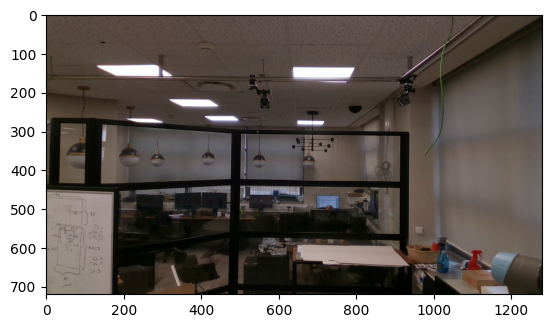

In [9]:
# get a frame, returns both rgb and depth
rgb, depth = camera.get_frame_rgb()

# visualize rgb:
plt.imshow(rgb)
plt.show()

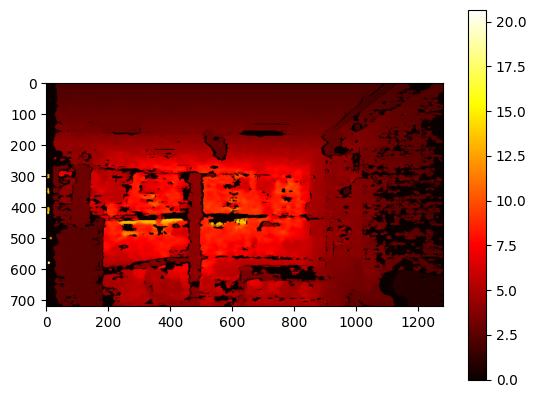

In [10]:
# visualize depth:
plt.imshow(depth, cmap='hot')
plt.colorbar()
plt.show()

As you can see, the depth image returns the distance in meters for each pixel. Note that it's noisy. Typically, you are probably not going to use it for scenes of more than 1-2 meters. Let's move the robot and take picture of the table and the surroundings.

In [11]:
robot.plan_and_moveJ([-np.pi/4, -np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, 0])

True

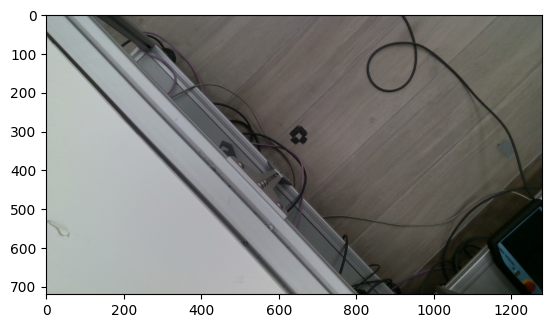

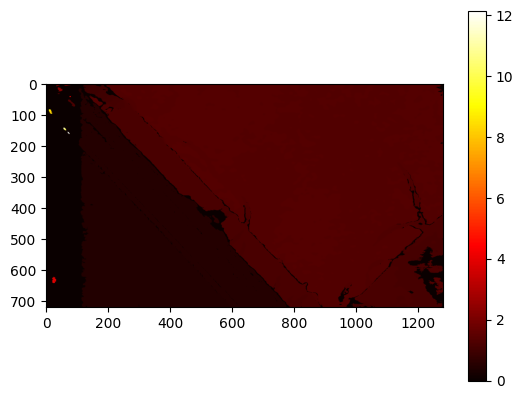

In [13]:
rgb, depth = camera.get_frame_rgb()
plt.imshow(rgb)
plt.show()

plt.imshow(depth, cmap='hot')
plt.colorbar()
plt.show()

Small noisy areas have pixels that shows too far distance and increase the scale. Let's clamp the depth to 2 meters to see better.

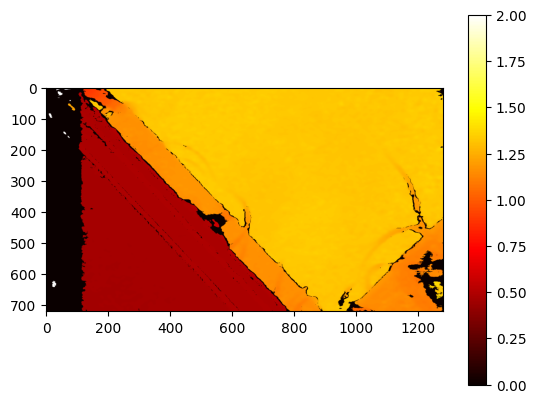

In [14]:
depth_clamped = np.clip(depth, 0, 2.0)
plt.imshow(depth_clamped, cmap='hot')
plt.colorbar()
plt.show()

Here is a simple example how you can use cv2 to continuously stream the camera frames. You can use this to stream the camera while moving the robot.

In [15]:
import cv2

# stream 200 frames, depth and rgb at about 30 fps while moving the robot:
q0 = robot.getActualQ()
q1 = q0.copy()
q1[0] = np.pi/8
# move between q1 and q0 asynchronously:
robot.move_path([q1, q0], speed=.5, acceleration=1, asynchronous=True)

# stream while moving:
for i in range(200):
    rgb, depth = camera.get_frame_rgb()
    depth_clamped = np.clip(depth, 0, 3.0)
    cv2.imshow('rgb', rgb)
    cv2.imshow('depth', depth_clamped)
    cv2.waitKey(33)

cv2.destroyAllWindows()

### Stereo Camera
The depth image from the realsense is produced through [stereo camera](https://en.wikipedia.org/wiki/Stereo_camera). The camera has two lenses and the depth is calculated by comparing the two images. The higher the offset of a point between the two cameras, the closer it is.
This has two main implications on the quality of our depth images:
1. They are noisy
2. The depth around the edges of nearby objects can't be calculated, since those points are visible to only one camera at a time. Note the black areas around objects in the depth image. When a point is not seen by both cameras, it's depth is set to zero.
3. The depth can't be computed for too nearby objects. In fact, the realsense camera (D415) can't "see" depth of more than 40cm. You have to consider that in your experiments

Let's demonstrate the third point. We stream the depth image while getting closer to the table, not how when we get too close, we see noise instead of the actual table depth (while the floor is still visible).

In [18]:
robot.plan_and_moveJ(q0)

# move down toward the table while streaming depth:
robot.moveL_relative([0, 0, -0.2, 0, 0, 0], speed=0.05, acceleration=0.2, asynchronous=True)
for i in range(100):
    _, depth = camera.get_frame_rgb()
    depth_clamped = np.clip(depth, 0, 3.0)
    cv2.imshow('depth', depth_clamped)
    cv2.waitKey(33)
time.sleep(1)

# move back up
robot.moveL_relative([0, 0, 0.2, 0, 0, 0], speed=0.05, acceleration=0.2, asynchronous=True)
for i in range(100):
    _, depth = camera.get_frame_rgb()
    depth_clamped = np.clip(depth, 0, 3.0)
    cv2.imshow('depth', depth_clamped)
    cv2.waitKey(33)

cv2.destroyAllWindows()


# Camera With Recording

In addition to getting frames for robot vision, the camera can also be useful to record an experiment for debugging or for offline processing of videos. There is a camera interface that supports that:

In [19]:
del camera

In [3]:
from ur_lab.camera.realsense_camera import RealsenseCameraWithRecording

camera_rec = RealsenseCameraWithRecording()

To start recording, we just call the appropriate method and pass a directory for where the video will be saved. It is a directory and not a file name becasue it records two videos: RGB and depth. Recordings are saved in the path you provided as two files with the prefixes: _color.mp and _depth.mp4. The recording is saved when stop_recording() is called.

There are other arguments you can pass to start recording:
- Desired FPS (default is 30)
- max depth distance (default is 5 meters). Depth in the recording will be claped to that value.

Note that the start_recording() is non blocking - the recording logic is ran on a another process, possibly parallel to your experiment. For example:

In [24]:
camera_rec.start_recording(file_path="test_recording/test_vid")

# can still get frames while recording:
rgb, depth = camera_rec.get_frame_rgb()

robot.plan_and_move_home()
robot.plan_and_moveJ(q0)

# don't forget to stop recording for the file to be saved:
camera_rec.stop_recording()


You can view the recordings

In [37]:
!ls test_recording

test_vid_color.mp4  test_vid_depth.mp4


For debugging, it is recommended to record the frames and perform your experiment inside a try block, and add finally block to stop the recording in case of failure. This way you will have the video even if there is a failure in your experiment.

```python
try:
    camera_rec.start_recording(file_name="test_recording.mp4")

    # your code here

finally:
    camera_rec.stop_recording()
    # your video is saved for debugging

```

# Vision

There are currently only basic vision modules which are practically examples of what you can do.
We will use one of them here for position estimation of objects.

**For preparation, put one of the wooden cubes on the table so it will be visible to the camera at q0.
make sure it's edges is parallel to the table edges (it's not rotated).**

We will use our Object Detection module. It is pretty simple, given an image, it provides a bounding box of an object. This is based on [YOLO-World](https://docs.ultralytics.com/models/yolo-world/) Model (Neural Network) which is very flexible: it can detect any object you specify via prompt (other versions of YOLO have limited number of classes of objects it can detect).
Here we create an instance of our object detector that can detect "wooden cube", "wooden block" and "wooden box". It will return a detection if it's confidence that it's a true detection is above 0.05.

In [ ]:
from ur_lab.vision.object_detection import ObjectDetection

classes = ['wooden cube', 'wooden block', 'wooden box']
detector = ObjectDetection(classes=classes, min_confidence=0.05)

Now Let's move the robot and capture an image of the object from the q0 configuration. We need to remember what configuration the robot was in when we took the image, since we will need it to localize the object in the world later.

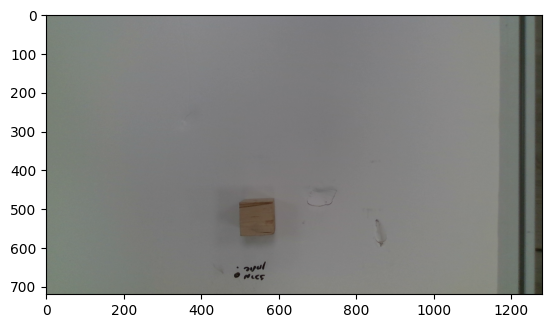

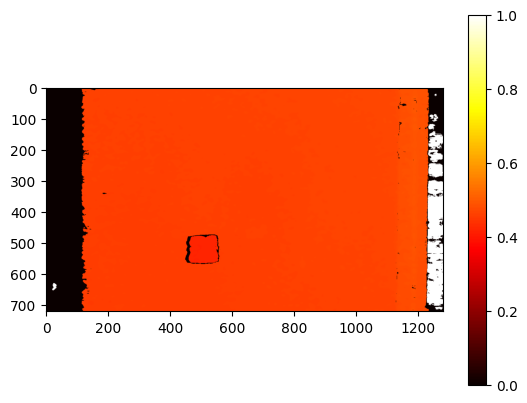

In [83]:
q0 = [0, -np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, 0]
robot.plan_and_moveJ(q0)
im, depth_im = camera_rec.get_frame_rgb()

# show image:
plt.imshow(im)
plt.show()
depth_im = np.clip(depth_im, 0, 1.0)
plt.imshow(depth_im, cmap='hot')
plt.colorbar()
plt.show()

Now let's pass the rgb image through the neural network and let it detect objects. The Neural networks accepts images in batches. We have only one image, so we will provide a batch of 1 image.

The detector returns
- coordinates of the bounding boxes for each image in the batch in the xyxy format (top left x, top left y, bottom right x, bottom right y)
- confidences corresponding to each detection in each image
- results object for each image that contains additional data including the original image

Note that we pass a batch, and get results for a batch. In our case, we have only one image in the batch.


0: 384x640 1 wooden cube, 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

----
bounding boxes xyxy and confidences: 
[(tensor([497.1910, 473.0021, 592.0519, 572.3045], device='cuda:0'), tensor(0.1733, device='cuda:0'))]


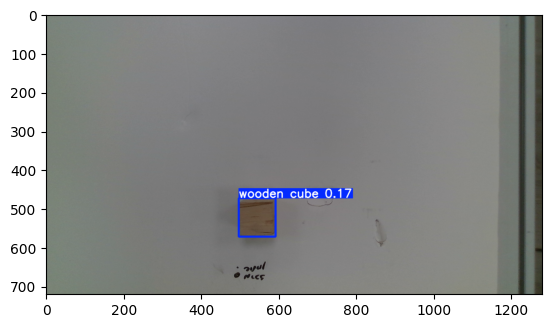

In [84]:
# a batch is expected. provide batch of 1 image
im_batch = [im]
bboxes, confidences, results = detector.detect_objects(im_batch)

#result is also returned as batch, we have only 1 element in the batch
bboxes, confidences, results = bboxes[0], confidences[0], results[0]

print()
print("----")
print("bounding boxes xyxy and confidences: ")
print(list(zip(bboxes, confidences)))

# results contains additional data. we can use it to easily plot:
im_annotated = detector.get_annotated_images(results)
plt.imshow(im_annotated)
plt.show()

### Finding the object in the world coordinates
This will be practice for some of the tools we already know (and for some basics of computer vision geometry).
Whatever you don't understand, please refer to online resources about camera geometry.

In [85]:
# take the first detection:
bbox = bboxes[0].cpu().numpy()
center = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]
center_int = [int(center[0]), int(center[1])]

# get the depth at the center of the bounding, average on a small area around the center:
window_in_depth = depth_im[center_int[1]-2:center_int[1]+2, center_int[0]-2:center_int[0]+2]
depth_pixels_in_window = window_in_depth.flatten()
# if some depth is zero, this is not a valid pixel:
window_in_depth = window_in_depth[window_in_depth > 0]
depth = np.mean(window_in_depth)

print("center of object in image: ", center_int)
print("depth at center: ", depth)

center of object in image:  [544, 522]
depth at center:  0.4190625199044007


cNeed to convert to 3D coordinates relative to camera coordinates. In camera coordinate system, Z is forward, Y is up, X is right. For this conversion we need to know the intrisic parameters of the camera. We can retrieve them from the camera API.

In [86]:
from ur_lab.camera.configurations_and_params import color_camera_intrinsic_matrix

fx = color_camera_intrinsic_matrix[0, 0]
fy = color_camera_intrinsic_matrix[1, 1]
ppx = color_camera_intrinsic_matrix[0, 2]
ppy = color_camera_intrinsic_matrix[1, 2]

x_cam = (center[0] - ppx) * depth / fx
y_cam = (center[1] - ppy) * depth / fy
z_cam = depth
p_cam = [x_cam, y_cam, z_cam]

print("object center in camera coordinates: ", p_cam)

object center in camera coordinates:  [-0.04359500958640223, 0.07372511789717008, 0.4190625199044007]


In [87]:
gt = robot.gt
point_world = gt.point_camera_to_world(p_cam, "ur5e_1", q0)

print("point in world coordinates: ", point_world)

point in world coordinates:  [0.533346881110016, -0.05000899041359782, 0.03402647984234447]


Does that make sense given the actual position?

In [88]:
camera_rec.start_recording(file_path="pick_up/vid")

try:
    pickup_point = point_world.copy()
    pickup_point[2] -= 0.01

    robot.pick_up_at_angle(pickup_point, [0, 0, 0.1])
    robot.put_down_at_angle([0.5, -0.2, 0.03], [0, 0, 0.1])
finally:
    camera_rec.stop_recording()

 ur_lab/vision/image_block_position_estimation.py is extended version of what we did here with some extra features. You may use it as reference for a slightly more complex version.